In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets   
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from timeit import default_timer as timer

In [2]:
class GoogLeNet(nn.Module):
    def __init__(self,in_channels=3,num_classes = 1000):
        super(GoogLeNet, self).__init__()
        self.conv1 = conv_block(in_channels=in_channels, out_channels=64, kernel_size = 7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = conv_block(64, 192, kernel_size = 3, stride = 1, padding = 1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #ORDER in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)

        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)

        return x

class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()

        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size = 1),
            conv_block(red_3x3, out_3x3, kernel_size = 3, stride = 1, padding =1),
        )
        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1),
            conv_block(red_5x5, out_5x5, kernel_size=5, stride = 1, padding = 2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1pool, kernel_size = 1),
        )

    def forward(self, x):
        # N x filters x 28 x 28
        #WE concatenate along the first dimension, essentially along the filters
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)


class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        #kwargs are keyword arguments
        super(conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))

In [3]:
#MNIST
#Setup train data
train_data = datasets.MNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))

test_data = datasets.MNIST(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_names, class_to_idx

(['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'],
 {'0 - zero': 0,
  '1 - one': 1,
  '2 - two': 2,
  '3 - three': 3,
  '4 - four': 4,
  '5 - five': 5,
  '6 - six': 6,
  '7 - seven': 7,
  '8 - eight': 8,
  '9 - nine': 9})

In [5]:
import torch.utils.data as data_utils

indices_train = torch.arange(1000)
indices_test = torch.arange(200)
train_data = data_utils.Subset(train_data, indices_train)
test_data = data_utils.Subset(test_data, indices_test)
len(train_data), len(test_data)

(1000, 200)

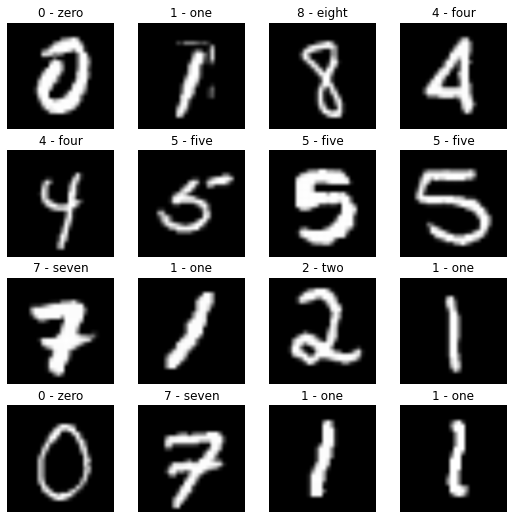

In [6]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [7]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 512
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
model_InceptionNET_0 = GoogLeNet(in_channels=1, num_classes=10).to(device)

In [3]:
def print_train_time(start:float,
                     end:float,
                     device:torch.device=None):
  total_time = end-start
  print(f"Train time on {device} : {total_time:.3f} seconds")
  return total_time

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_InceptionNET_0.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
#Functionizing training and evaluation/testing loops
#We create a function for training loop - train_step()
#testing loop - test_step()

def train_step(model:torch.nn.Module, data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device=device):
  #Performs training step on model trying to learn from data loader
  train_loss, train_acc = 0, 0
  #Put model in training mode
  model.train()
  #Add a loop through the training batches 
  for batch, (X,y) in enumerate(data_loader):#Enumerate helps keeping track of batches
    #Put data on target device
    X,y = X.to(device), y.to(device)
    #forward pass
    y_pred = model(X)
    #loss and accuracy
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    #Optimizer zero grad
    optimizer.zero_grad()
    #Loss backward
    loss.backward()
    #Step
    optimizer.step()

  #Adjust the training loss so that it gives us the loss per epoch an not per batch
  #Divide total train loss by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Loss: {train_loss:.5f}, Train acc: {train_acc:.2f}%")

In [17]:
def test_step(model:torch.nn.Module, data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device=device):
  #Performs training step on model trying to learn from data loader
  test_loss, test_acc = 0, 0
  #Put model in training mode
  model.eval()
  #Add a loop through the training batches 
  with torch.inference_mode():
    for X,y in data_loader:#Enumerate helps keeping track of batches
      #Put data on target device
      X,y = X.to(device), y.to(device)
      #forward pass
      test_pred = model(X)
      #loss and accuracy
      loss = loss_fn(test_pred, y)
      test_loss += loss
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    #Adjust the training loss so that it gives us the loss per epoch an not per batch
    #Divide total train loss by length of train dataloader
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [13]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=50

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_InceptionNET_0, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_InceptionNET_0,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 ----


  2%|▏         | 1/50 [00:09<07:43,  9.46s/it]

Train Loss: 2.29392, Train acc: 15.60%
Test Loss: 2.30099, Test acc: 8.50%
Epoch: 1 ----


  4%|▍         | 2/50 [00:10<03:35,  4.50s/it]

Train Loss: 2.20856, Train acc: 23.39%
Test Loss: 2.29556, Test acc: 14.00%
Epoch: 2 ----


  6%|▌         | 3/50 [00:11<02:16,  2.90s/it]

Train Loss: 2.09662, Train acc: 29.90%
Test Loss: 2.28823, Test acc: 14.00%
Epoch: 3 ----


  8%|▊         | 4/50 [00:12<01:39,  2.15s/it]

Train Loss: 1.96725, Train acc: 39.69%
Test Loss: 2.28124, Test acc: 14.00%
Epoch: 4 ----


 10%|█         | 5/50 [00:13<01:18,  1.74s/it]

Train Loss: 1.81989, Train acc: 48.77%
Test Loss: 2.28014, Test acc: 14.00%
Epoch: 5 ----


 12%|█▏        | 6/50 [00:14<01:05,  1.49s/it]

Train Loss: 1.62915, Train acc: 64.32%
Test Loss: 2.29229, Test acc: 14.00%
Epoch: 6 ----


 14%|█▍        | 7/50 [00:15<00:57,  1.33s/it]

Train Loss: 1.44250, Train acc: 73.58%
Test Loss: 2.32383, Test acc: 14.00%
Epoch: 7 ----


 16%|█▌        | 8/50 [00:16<00:51,  1.23s/it]

Train Loss: 1.26863, Train acc: 79.24%
Test Loss: 2.38315, Test acc: 14.00%
Epoch: 8 ----


 18%|█▊        | 9/50 [00:17<00:47,  1.17s/it]

Train Loss: 1.07785, Train acc: 85.45%
Test Loss: 2.48568, Test acc: 14.00%
Epoch: 9 ----


 20%|██        | 10/50 [00:18<00:44,  1.12s/it]

Train Loss: 0.96345, Train acc: 85.02%
Test Loss: 2.63057, Test acc: 14.00%
Epoch: 10 ----


 22%|██▏       | 11/50 [00:19<00:42,  1.08s/it]

Train Loss: 0.86685, Train acc: 88.00%
Test Loss: 2.83117, Test acc: 14.00%
Epoch: 11 ----


 24%|██▍       | 12/50 [00:20<00:40,  1.06s/it]

Train Loss: 0.70788, Train acc: 90.95%
Test Loss: 3.09185, Test acc: 14.00%
Epoch: 12 ----


 26%|██▌       | 13/50 [00:21<00:38,  1.05s/it]

Train Loss: 0.55825, Train acc: 94.23%
Test Loss: 3.36895, Test acc: 14.00%
Epoch: 13 ----


 28%|██▊       | 14/50 [00:22<00:37,  1.03s/it]

Train Loss: 0.51506, Train acc: 94.39%
Test Loss: 3.68040, Test acc: 14.00%
Epoch: 14 ----


 30%|███       | 15/50 [00:23<00:35,  1.03s/it]

Train Loss: 0.42814, Train acc: 95.71%
Test Loss: 3.92296, Test acc: 14.00%
Epoch: 15 ----


 32%|███▏      | 16/50 [00:24<00:34,  1.02s/it]

Train Loss: 0.35721, Train acc: 96.80%
Test Loss: 4.11001, Test acc: 14.00%
Epoch: 16 ----


 34%|███▍      | 17/50 [00:25<00:33,  1.01s/it]

Train Loss: 0.30336, Train acc: 97.38%
Test Loss: 4.24382, Test acc: 14.00%
Epoch: 17 ----


 36%|███▌      | 18/50 [00:26<00:32,  1.01s/it]

Train Loss: 0.26569, Train acc: 98.31%
Test Loss: 4.24974, Test acc: 14.00%
Epoch: 18 ----


 38%|███▊      | 19/50 [00:27<00:31,  1.02s/it]

Train Loss: 0.23994, Train acc: 98.29%
Test Loss: 4.08989, Test acc: 14.00%
Epoch: 19 ----


 40%|████      | 20/50 [00:28<00:30,  1.01s/it]

Train Loss: 0.21411, Train acc: 98.90%
Test Loss: 3.99281, Test acc: 14.00%
Epoch: 20 ----


 42%|████▏     | 21/50 [00:29<00:29,  1.01s/it]

Train Loss: 0.18190, Train acc: 99.10%
Test Loss: 3.78060, Test acc: 14.00%
Epoch: 21 ----


 44%|████▍     | 22/50 [00:30<00:28,  1.01s/it]

Train Loss: 0.16268, Train acc: 99.10%
Test Loss: 3.61042, Test acc: 14.50%
Epoch: 22 ----


 46%|████▌     | 23/50 [00:31<00:27,  1.01s/it]

Train Loss: 0.15284, Train acc: 99.30%
Test Loss: 3.18535, Test acc: 15.50%
Epoch: 23 ----


 48%|████▊     | 24/50 [00:32<00:26,  1.01s/it]

Train Loss: 0.14882, Train acc: 99.11%
Test Loss: 2.97317, Test acc: 20.00%
Epoch: 24 ----


 50%|█████     | 25/50 [00:33<00:25,  1.00s/it]

Train Loss: 0.12088, Train acc: 99.60%
Test Loss: 2.62317, Test acc: 22.00%
Epoch: 25 ----


 52%|█████▏    | 26/50 [00:34<00:24,  1.03s/it]

Train Loss: 0.10774, Train acc: 99.60%
Test Loss: 2.25610, Test acc: 25.50%
Epoch: 26 ----


 54%|█████▍    | 27/50 [00:35<00:23,  1.04s/it]

Train Loss: 0.09411, Train acc: 99.70%
Test Loss: 1.80905, Test acc: 35.00%
Epoch: 27 ----


 56%|█████▌    | 28/50 [00:36<00:22,  1.03s/it]

Train Loss: 0.09105, Train acc: 99.60%
Test Loss: 1.34624, Test acc: 44.50%
Epoch: 28 ----


 58%|█████▊    | 29/50 [00:37<00:21,  1.02s/it]

Train Loss: 0.08390, Train acc: 99.70%
Test Loss: 1.09217, Test acc: 57.50%
Epoch: 29 ----


 60%|██████    | 30/50 [00:38<00:20,  1.02s/it]

Train Loss: 0.07527, Train acc: 99.80%
Test Loss: 0.83252, Test acc: 72.00%
Epoch: 30 ----


 62%|██████▏   | 31/50 [00:39<00:19,  1.02s/it]

Train Loss: 0.06896, Train acc: 99.80%
Test Loss: 0.54821, Test acc: 86.50%
Epoch: 31 ----


 64%|██████▍   | 32/50 [00:40<00:18,  1.01s/it]

Train Loss: 0.06354, Train acc: 99.90%
Test Loss: 0.43575, Test acc: 92.00%
Epoch: 32 ----


 66%|██████▌   | 33/50 [00:41<00:17,  1.01s/it]

Train Loss: 0.05800, Train acc: 100.00%
Test Loss: 0.53084, Test acc: 83.50%
Epoch: 33 ----


 68%|██████▊   | 34/50 [00:42<00:16,  1.01s/it]

Train Loss: 0.05230, Train acc: 99.90%
Test Loss: 0.45688, Test acc: 88.50%
Epoch: 34 ----


 70%|███████   | 35/50 [00:43<00:15,  1.01s/it]

Train Loss: 0.05014, Train acc: 99.90%
Test Loss: 0.40979, Test acc: 90.00%
Epoch: 35 ----


 72%|███████▏  | 36/50 [00:44<00:14,  1.01s/it]

Train Loss: 0.05040, Train acc: 100.00%
Test Loss: 0.31296, Test acc: 95.00%
Epoch: 36 ----


 74%|███████▍  | 37/50 [00:45<00:13,  1.01s/it]

Train Loss: 0.04522, Train acc: 100.00%
Test Loss: 0.28645, Test acc: 96.00%
Epoch: 37 ----


 76%|███████▌  | 38/50 [00:46<00:12,  1.01s/it]

Train Loss: 0.04212, Train acc: 100.00%
Test Loss: 0.24153, Test acc: 97.50%
Epoch: 38 ----


 78%|███████▊  | 39/50 [00:47<00:11,  1.01s/it]

Train Loss: 0.03899, Train acc: 100.00%
Test Loss: 0.18516, Test acc: 98.00%
Epoch: 39 ----


 80%|████████  | 40/50 [00:48<00:10,  1.00s/it]

Train Loss: 0.03798, Train acc: 100.00%
Test Loss: 0.17952, Test acc: 98.50%
Epoch: 40 ----


 82%|████████▏ | 41/50 [00:49<00:09,  1.00s/it]

Train Loss: 0.03566, Train acc: 100.00%
Test Loss: 0.18164, Test acc: 98.50%
Epoch: 41 ----


 84%|████████▍ | 42/50 [00:50<00:08,  1.00s/it]

Train Loss: 0.03343, Train acc: 100.00%
Test Loss: 0.19660, Test acc: 97.50%
Epoch: 42 ----


 86%|████████▌ | 43/50 [00:51<00:07,  1.01s/it]

Train Loss: 0.03278, Train acc: 100.00%
Test Loss: 0.17369, Test acc: 98.50%
Epoch: 43 ----


 88%|████████▊ | 44/50 [00:52<00:06,  1.01s/it]

Train Loss: 0.03048, Train acc: 100.00%
Test Loss: 0.14622, Test acc: 98.50%
Epoch: 44 ----


 90%|█████████ | 45/50 [00:53<00:05,  1.01s/it]

Train Loss: 0.02910, Train acc: 100.00%
Test Loss: 0.14890, Test acc: 98.50%
Epoch: 45 ----


 92%|█████████▏| 46/50 [00:54<00:04,  1.01s/it]

Train Loss: 0.02668, Train acc: 100.00%
Test Loss: 0.14069, Test acc: 98.50%
Epoch: 46 ----


 94%|█████████▍| 47/50 [00:55<00:03,  1.01s/it]

Train Loss: 0.02624, Train acc: 100.00%
Test Loss: 0.13516, Test acc: 98.50%
Epoch: 47 ----


 96%|█████████▌| 48/50 [00:56<00:02,  1.01s/it]

Train Loss: 0.02505, Train acc: 100.00%
Test Loss: 0.13299, Test acc: 98.50%
Epoch: 48 ----


 98%|█████████▊| 49/50 [00:57<00:01,  1.01s/it]

Train Loss: 0.02565, Train acc: 100.00%
Test Loss: 0.14014, Test acc: 98.50%
Epoch: 49 ----


100%|██████████| 50/50 [00:59<00:00,  1.18s/it]

Train Loss: 0.02329, Train acc: 100.00%
Test Loss: 0.13774, Test acc: 98.50%
Train time on cuda : 59.012 seconds


In [18]:
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device=device):
  loss,acc = 0, 0
  #Returns a dictionary containing the results of the model predicting on data_loader
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      X,y = X.to(device), y.to(device)
      #Make predictions
      y_pred = model(X)

      #Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))
    #Scale the loss and acc to find the average loss and acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name":model.__class__.__name__,
          "model_loss":loss.item(),
          "model_acc":acc}

In [15]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "00_InceptionNET_MNISTpth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [16]:
#Saving the model
torch.save(obj=model_InceptionNET_0.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models/00_InceptionNET_MNISTpth


In [17]:
#Loading the model
#Create a new instance of the model and update the parameters
model_InceptionNET_MNIST = GoogLeNet(in_channels=1, num_classes=10).to(device)
model_InceptionNET_MNIST.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [18]:
#Get model results
model_InceptionNET_MNIST_results = eval_model(
    model=model_InceptionNET_MNIST,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_InceptionNET_MNIST_results

100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


{'model_name': 'GoogLeNet',
 'model_loss': 0.13773691654205322,
 'model_acc': 98.5}

In [19]:
#FashionMNIST
train_data = datasets.FashionMNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))

test_data = datasets.FashionMNIST(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [20]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_names, class_to_idx

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 {'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9})

In [21]:
import torch.utils.data as data_utils

indices_train = torch.arange(1000)
indices_test = torch.arange(200)
train_data = data_utils.Subset(train_data, indices_train)
test_data = data_utils.Subset(test_data, indices_test)
len(train_data), len(test_data)

(1000, 200)

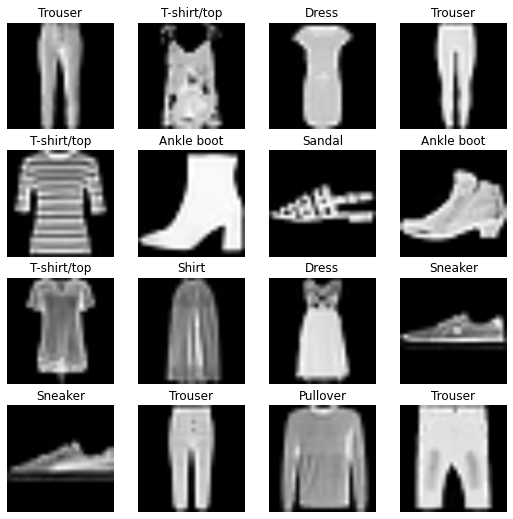

In [22]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [23]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 512
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [24]:
model_InceptionNET_1 = GoogLeNet(in_channels=1, num_classes=10).to(device)

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_InceptionNET_1.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [26]:
#TRAINING AND TESTING

In [27]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=50

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_InceptionNET_1, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_InceptionNET_1,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 ----


  2%|▏         | 1/50 [00:01<00:50,  1.04s/it]

Train Loss: 2.30961, Train acc: 12.89%
Test Loss: 2.30264, Test acc: 10.00%
Epoch: 1 ----


  4%|▍         | 2/50 [00:02<00:49,  1.03s/it]

Train Loss: 2.19955, Train acc: 23.26%
Test Loss: 2.30416, Test acc: 10.00%
Epoch: 2 ----


  6%|▌         | 3/50 [00:03<00:48,  1.03s/it]

Train Loss: 2.05063, Train acc: 33.76%
Test Loss: 2.30669, Test acc: 10.00%
Epoch: 3 ----


  8%|▊         | 4/50 [00:04<00:46,  1.02s/it]

Train Loss: 1.90632, Train acc: 37.99%
Test Loss: 2.31046, Test acc: 10.00%
Epoch: 4 ----


 10%|█         | 5/50 [00:05<00:45,  1.02s/it]

Train Loss: 1.73845, Train acc: 46.43%
Test Loss: 2.31484, Test acc: 8.50%
Epoch: 5 ----


 12%|█▏        | 6/50 [00:06<00:44,  1.02s/it]

Train Loss: 1.56599, Train acc: 56.02%
Test Loss: 2.32104, Test acc: 8.50%
Epoch: 6 ----


 14%|█▍        | 7/50 [00:07<00:43,  1.01s/it]

Train Loss: 1.42232, Train acc: 59.42%
Test Loss: 2.32906, Test acc: 8.50%
Epoch: 7 ----


 16%|█▌        | 8/50 [00:08<00:42,  1.01s/it]

Train Loss: 1.28238, Train acc: 66.22%
Test Loss: 2.34478, Test acc: 8.50%
Epoch: 8 ----


 18%|█▊        | 9/50 [00:09<00:41,  1.01s/it]

Train Loss: 1.16406, Train acc: 69.11%
Test Loss: 2.35796, Test acc: 8.50%
Epoch: 9 ----


 20%|██        | 10/50 [00:10<00:40,  1.01s/it]

Train Loss: 1.05993, Train acc: 74.40%
Test Loss: 2.37625, Test acc: 8.50%
Epoch: 10 ----


 22%|██▏       | 11/50 [00:11<00:39,  1.01s/it]

Train Loss: 0.98116, Train acc: 73.43%
Test Loss: 2.39302, Test acc: 8.50%
Epoch: 11 ----


 24%|██▍       | 12/50 [00:12<00:38,  1.00s/it]

Train Loss: 0.91167, Train acc: 74.85%
Test Loss: 2.41231, Test acc: 8.50%
Epoch: 12 ----


 26%|██▌       | 13/50 [00:13<00:37,  1.01s/it]

Train Loss: 0.82770, Train acc: 79.12%
Test Loss: 2.42457, Test acc: 8.50%
Epoch: 13 ----


 28%|██▊       | 14/50 [00:14<00:36,  1.01s/it]

Train Loss: 0.76938, Train acc: 78.95%
Test Loss: 2.40626, Test acc: 9.50%
Epoch: 14 ----


 30%|███       | 15/50 [00:15<00:35,  1.01s/it]

Train Loss: 0.75379, Train acc: 79.00%
Test Loss: 2.37630, Test acc: 13.00%
Epoch: 15 ----


 32%|███▏      | 16/50 [00:16<00:34,  1.01s/it]

Train Loss: 0.70088, Train acc: 81.17%
Test Loss: 2.34625, Test acc: 15.50%
Epoch: 16 ----


 34%|███▍      | 17/50 [00:17<00:33,  1.01s/it]

Train Loss: 0.66564, Train acc: 79.62%
Test Loss: 2.29564, Test acc: 12.50%
Epoch: 17 ----


 36%|███▌      | 18/50 [00:18<00:32,  1.01s/it]

Train Loss: 0.61790, Train acc: 81.94%
Test Loss: 2.20161, Test acc: 17.00%
Epoch: 18 ----


 38%|███▊      | 19/50 [00:19<00:31,  1.01s/it]

Train Loss: 0.56062, Train acc: 83.56%
Test Loss: 2.16746, Test acc: 23.50%
Epoch: 19 ----


 40%|████      | 20/50 [00:20<00:30,  1.01s/it]

Train Loss: 0.53713, Train acc: 85.60%
Test Loss: 1.98260, Test acc: 29.50%
Epoch: 20 ----


 42%|████▏     | 21/50 [00:21<00:29,  1.01s/it]

Train Loss: 0.51858, Train acc: 85.14%
Test Loss: 1.85702, Test acc: 29.00%
Epoch: 21 ----


 44%|████▍     | 22/50 [00:22<00:28,  1.01s/it]

Train Loss: 0.49216, Train acc: 87.54%
Test Loss: 1.59475, Test acc: 38.50%
Epoch: 22 ----


 46%|████▌     | 23/50 [00:23<00:27,  1.01s/it]

Train Loss: 0.46049, Train acc: 87.04%
Test Loss: 1.50472, Test acc: 40.00%
Epoch: 23 ----


 48%|████▊     | 24/50 [00:24<00:26,  1.01s/it]

Train Loss: 0.44701, Train acc: 87.13%
Test Loss: 1.61999, Test acc: 32.50%
Epoch: 24 ----


 50%|█████     | 25/50 [00:25<00:25,  1.01s/it]

Train Loss: 0.45149, Train acc: 87.70%
Test Loss: 1.17833, Test acc: 51.50%
Epoch: 25 ----


 52%|█████▏    | 26/50 [00:26<00:24,  1.01s/it]

Train Loss: 0.37956, Train acc: 89.63%
Test Loss: 0.99102, Test acc: 61.00%
Epoch: 26 ----


 54%|█████▍    | 27/50 [00:27<00:23,  1.01s/it]

Train Loss: 0.35693, Train acc: 91.47%
Test Loss: 0.93538, Test acc: 64.50%
Epoch: 27 ----


 56%|█████▌    | 28/50 [00:28<00:22,  1.01s/it]

Train Loss: 0.35258, Train acc: 90.99%
Test Loss: 0.86388, Test acc: 67.50%
Epoch: 28 ----


 58%|█████▊    | 29/50 [00:29<00:21,  1.01s/it]

Train Loss: 0.36052, Train acc: 90.58%
Test Loss: 0.74932, Test acc: 71.50%
Epoch: 29 ----


 60%|██████    | 30/50 [00:30<00:20,  1.01s/it]

Train Loss: 0.35319, Train acc: 90.79%
Test Loss: 0.89003, Test acc: 66.00%
Epoch: 30 ----


 62%|██████▏   | 31/50 [00:31<00:19,  1.01s/it]

Train Loss: 0.35059, Train acc: 89.91%
Test Loss: 0.76967, Test acc: 71.00%
Epoch: 31 ----


 64%|██████▍   | 32/50 [00:32<00:18,  1.01s/it]

Train Loss: 0.27433, Train acc: 94.61%
Test Loss: 0.60563, Test acc: 78.50%
Epoch: 32 ----


 66%|██████▌   | 33/50 [00:33<00:17,  1.01s/it]

Train Loss: 0.26937, Train acc: 93.50%
Test Loss: 1.08461, Test acc: 63.00%
Epoch: 33 ----


 68%|██████▊   | 34/50 [00:34<00:16,  1.01s/it]

Train Loss: 0.31063, Train acc: 91.26%
Test Loss: 0.72625, Test acc: 71.50%
Epoch: 34 ----


 70%|███████   | 35/50 [00:35<00:15,  1.01s/it]

Train Loss: 0.26249, Train acc: 93.59%
Test Loss: 0.87597, Test acc: 69.50%
Epoch: 35 ----


 72%|███████▏  | 36/50 [00:36<00:14,  1.01s/it]

Train Loss: 0.26946, Train acc: 92.90%
Test Loss: 0.62366, Test acc: 77.00%
Epoch: 36 ----


 74%|███████▍  | 37/50 [00:37<00:13,  1.01s/it]

Train Loss: 0.25175, Train acc: 94.07%
Test Loss: 0.69740, Test acc: 78.50%
Epoch: 37 ----


 76%|███████▌  | 38/50 [00:38<00:12,  1.02s/it]

Train Loss: 0.21935, Train acc: 95.01%
Test Loss: 0.56360, Test acc: 80.00%
Epoch: 38 ----


 78%|███████▊  | 39/50 [00:39<00:11,  1.02s/it]

Train Loss: 0.15344, Train acc: 98.13%
Test Loss: 0.54678, Test acc: 81.50%
Epoch: 39 ----


 80%|████████  | 40/50 [00:40<00:10,  1.02s/it]

Train Loss: 0.13810, Train acc: 98.91%
Test Loss: 0.55638, Test acc: 81.50%
Epoch: 40 ----


 82%|████████▏ | 41/50 [00:41<00:09,  1.02s/it]

Train Loss: 0.16756, Train acc: 96.57%
Test Loss: 0.92444, Test acc: 72.00%
Epoch: 41 ----


 84%|████████▍ | 42/50 [00:42<00:08,  1.02s/it]

Train Loss: 0.26182, Train acc: 92.13%
Test Loss: 0.85797, Test acc: 71.00%
Epoch: 42 ----


 86%|████████▌ | 43/50 [00:43<00:07,  1.01s/it]

Train Loss: 0.17298, Train acc: 96.71%
Test Loss: 0.73788, Test acc: 75.00%
Epoch: 43 ----


 88%|████████▊ | 44/50 [00:44<00:06,  1.01s/it]

Train Loss: 0.16937, Train acc: 95.68%
Test Loss: 0.83964, Test acc: 73.50%
Epoch: 44 ----


 90%|█████████ | 45/50 [00:45<00:05,  1.01s/it]

Train Loss: 0.20692, Train acc: 94.70%
Test Loss: 0.60877, Test acc: 80.50%
Epoch: 45 ----


 92%|█████████▏| 46/50 [00:46<00:04,  1.01s/it]

Train Loss: 0.12987, Train acc: 97.93%
Test Loss: 0.56353, Test acc: 79.50%
Epoch: 46 ----


 94%|█████████▍| 47/50 [00:47<00:03,  1.01s/it]

Train Loss: 0.08669, Train acc: 99.40%
Test Loss: 0.56558, Test acc: 82.50%
Epoch: 47 ----


 96%|█████████▌| 48/50 [00:48<00:02,  1.01s/it]

Train Loss: 0.06647, Train acc: 100.00%
Test Loss: 0.52702, Test acc: 81.50%
Epoch: 48 ----


 98%|█████████▊| 49/50 [00:49<00:01,  1.01s/it]

Train Loss: 0.05753, Train acc: 100.00%
Test Loss: 0.52766, Test acc: 81.00%
Epoch: 49 ----


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]

Train Loss: 0.05101, Train acc: 100.00%
Test Loss: 0.52220, Test acc: 80.00%
Train time on cuda : 50.526 seconds


In [28]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "01_InceptionNET_FashionMNISTpth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [29]:
#Saving the model
torch.save(obj=model_InceptionNET_1.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models/01_InceptionNET_FashionMNISTpth


In [30]:
#Loading the model
#Create a new instance of the model and update the parameters
model_InceptionNET_FashionMNIST = GoogLeNet(in_channels=1, num_classes=10).to(device)
model_InceptionNET_FashionMNIST.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [31]:
#Get model results
model_InceptionNET_FashionMNIST_results = eval_model(
    model=model_InceptionNET_FashionMNIST,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_InceptionNET_FashionMNIST_results

100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


{'model_name': 'GoogLeNet',
 'model_loss': 0.5222022533416748,
 'model_acc': 80.0}

In [32]:
#CIFAR 10
train_data = datasets.CIFAR10(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.Compose([transforms.Grayscale(),transforms.Resize(size=(224,224)),transforms.ToTensor()]))

test_data = datasets.CIFAR10(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([transforms.Grayscale(),transforms.Resize(size=(224,224)),transforms.ToTensor()]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [33]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_names, class_to_idx

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 {'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9})

In [34]:
import torch.utils.data as data_utils

indices_train = torch.arange(10000)
indices_test = torch.arange(2000)
train_data = data_utils.Subset(train_data, indices_train)
test_data = data_utils.Subset(test_data, indices_test)
len(train_data), len(test_data)

(10000, 2000)

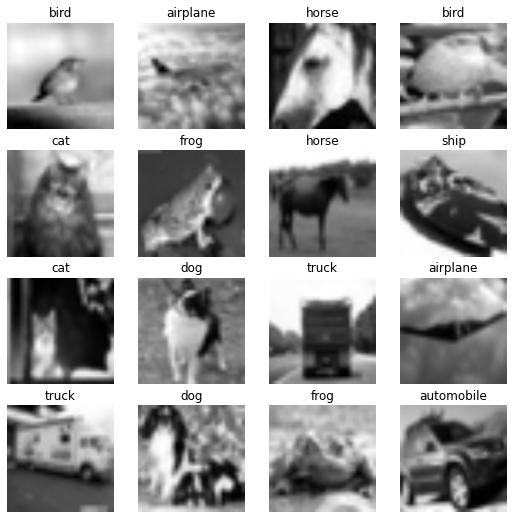

In [35]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [36]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 512
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [37]:
model_InceptionNET_2 = GoogLeNet(in_channels=1, num_classes=10).to(device)

In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_InceptionNET_2.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [39]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=50

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_InceptionNET_2, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_InceptionNET_2,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 2.16058, Train acc: 20.46%


  2%|▏         | 1/50 [00:09<07:26,  9.11s/it]

Test Loss: 2.50230, Test acc: 9.93%
Epoch: 1 ----
Train Loss: 1.88705, Train acc: 30.89%


  4%|▍         | 2/50 [00:18<07:17,  9.11s/it]

Test Loss: 2.98870, Test acc: 10.38%
Epoch: 2 ----
Train Loss: 1.72521, Train acc: 36.97%


  6%|▌         | 3/50 [00:27<07:06,  9.08s/it]

Test Loss: 1.82207, Test acc: 33.40%
Epoch: 3 ----
Train Loss: 1.59296, Train acc: 42.26%


  8%|▊         | 4/50 [00:36<07:01,  9.17s/it]

Test Loss: 1.71401, Test acc: 38.15%
Epoch: 4 ----
Train Loss: 1.50527, Train acc: 45.91%


 10%|█         | 5/50 [00:45<06:50,  9.13s/it]

Test Loss: 2.14315, Test acc: 32.35%
Epoch: 5 ----
Train Loss: 1.38564, Train acc: 51.11%


 12%|█▏        | 6/50 [00:54<06:40,  9.09s/it]

Test Loss: 1.86369, Test acc: 33.64%
Epoch: 6 ----
Train Loss: 1.31233, Train acc: 53.01%


 14%|█▍        | 7/50 [01:03<06:31,  9.10s/it]

Test Loss: 2.15301, Test acc: 24.99%
Epoch: 7 ----
Train Loss: 1.22360, Train acc: 56.26%


 16%|█▌        | 8/50 [01:12<06:20,  9.06s/it]

Test Loss: 2.25148, Test acc: 38.26%
Epoch: 8 ----
Train Loss: 1.15845, Train acc: 58.55%


 18%|█▊        | 9/50 [01:21<06:11,  9.05s/it]

Test Loss: 2.11479, Test acc: 32.18%
Epoch: 9 ----
Train Loss: 1.12855, Train acc: 59.72%


 20%|██        | 10/50 [01:30<06:01,  9.04s/it]

Test Loss: 2.09262, Test acc: 33.30%
Epoch: 10 ----
Train Loss: 1.03532, Train acc: 63.18%


 22%|██▏       | 11/50 [01:40<05:55,  9.13s/it]

Test Loss: 1.69152, Test acc: 40.54%
Epoch: 11 ----
Train Loss: 0.96064, Train acc: 66.20%


 24%|██▍       | 12/50 [01:49<05:45,  9.10s/it]

Test Loss: 1.53618, Test acc: 48.74%
Epoch: 12 ----
Train Loss: 0.94260, Train acc: 67.10%


 26%|██▌       | 13/50 [01:58<05:36,  9.09s/it]

Test Loss: 2.38562, Test acc: 38.79%
Epoch: 13 ----
Train Loss: 0.85741, Train acc: 70.20%


 28%|██▊       | 14/50 [02:07<05:26,  9.07s/it]

Test Loss: 3.05457, Test acc: 31.04%
Epoch: 14 ----
Train Loss: 0.78286, Train acc: 72.82%


 30%|███       | 15/50 [02:16<05:17,  9.06s/it]

Test Loss: 2.22670, Test acc: 36.27%
Epoch: 15 ----
Train Loss: 0.73710, Train acc: 74.50%


 32%|███▏      | 16/50 [02:25<05:07,  9.05s/it]

Test Loss: 2.16658, Test acc: 43.12%
Epoch: 16 ----
Train Loss: 0.64949, Train acc: 77.73%


 34%|███▍      | 17/50 [02:34<04:58,  9.04s/it]

Test Loss: 3.57081, Test acc: 19.33%
Epoch: 17 ----
Train Loss: 0.66237, Train acc: 76.86%


 36%|███▌      | 18/50 [02:43<04:49,  9.04s/it]

Test Loss: 1.93515, Test acc: 40.03%
Epoch: 18 ----
Train Loss: 0.55797, Train acc: 81.67%


 38%|███▊      | 19/50 [02:52<04:40,  9.04s/it]

Test Loss: 13.14837, Test acc: 11.52%
Epoch: 19 ----
Train Loss: 0.53709, Train acc: 81.93%


 40%|████      | 20/50 [03:01<04:30,  9.03s/it]

Test Loss: 2.11145, Test acc: 40.95%
Epoch: 20 ----
Train Loss: 0.40362, Train acc: 87.28%


 42%|████▏     | 21/50 [03:10<04:21,  9.02s/it]

Test Loss: 2.25742, Test acc: 42.79%
Epoch: 21 ----
Train Loss: 0.35362, Train acc: 89.32%


 44%|████▍     | 22/50 [03:19<04:12,  9.02s/it]

Test Loss: 1.33468, Test acc: 57.45%
Epoch: 22 ----
Train Loss: 0.25427, Train acc: 93.10%


 46%|████▌     | 23/50 [03:28<04:03,  9.02s/it]

Test Loss: 2.05115, Test acc: 44.02%
Epoch: 23 ----
Train Loss: 0.40524, Train acc: 86.99%


 48%|████▊     | 24/50 [03:37<03:54,  9.02s/it]

Test Loss: 1.50252, Test acc: 54.87%
Epoch: 24 ----
Train Loss: 0.12932, Train acc: 97.45%


 50%|█████     | 25/50 [03:46<03:45,  9.02s/it]

Test Loss: 1.15326, Test acc: 63.02%
Epoch: 25 ----
Train Loss: 0.06353, Train acc: 99.38%


 52%|█████▏    | 26/50 [03:55<03:36,  9.01s/it]

Test Loss: 1.06374, Test acc: 66.36%
Epoch: 26 ----
Train Loss: 0.03760, Train acc: 99.83%


 54%|█████▍    | 27/50 [04:04<03:27,  9.01s/it]

Test Loss: 1.12941, Test acc: 65.01%
Epoch: 27 ----
Train Loss: 0.02495, Train acc: 99.98%


 56%|█████▌    | 28/50 [04:13<03:18,  9.01s/it]

Test Loss: 1.11032, Test acc: 66.26%
Epoch: 28 ----
Train Loss: 0.01900, Train acc: 99.99%


 58%|█████▊    | 29/50 [04:22<03:09,  9.03s/it]

Test Loss: 1.04548, Test acc: 68.02%
Epoch: 29 ----
Train Loss: 0.01471, Train acc: 100.00%


 60%|██████    | 30/50 [04:31<03:00,  9.05s/it]

Test Loss: 1.05643, Test acc: 67.65%
Epoch: 30 ----
Train Loss: 0.01175, Train acc: 100.00%


 62%|██████▏   | 31/50 [04:40<02:51,  9.04s/it]

Test Loss: 1.05898, Test acc: 67.24%
Epoch: 31 ----
Train Loss: 0.01099, Train acc: 100.00%


 64%|██████▍   | 32/50 [04:49<02:42,  9.03s/it]

Test Loss: 1.08078, Test acc: 66.64%
Epoch: 32 ----
Train Loss: 0.00868, Train acc: 100.00%


 66%|██████▌   | 33/50 [04:58<02:33,  9.02s/it]

Test Loss: 1.06163, Test acc: 68.14%
Epoch: 33 ----
Train Loss: 0.00780, Train acc: 100.00%


 68%|██████▊   | 34/50 [05:07<02:24,  9.02s/it]

Test Loss: 1.07847, Test acc: 67.44%
Epoch: 34 ----
Train Loss: 0.00695, Train acc: 100.00%


 70%|███████   | 35/50 [05:16<02:15,  9.03s/it]

Test Loss: 1.08198, Test acc: 67.88%
Epoch: 35 ----
Train Loss: 0.00630, Train acc: 100.00%


 72%|███████▏  | 36/50 [05:25<02:06,  9.01s/it]

Test Loss: 1.08715, Test acc: 67.22%
Epoch: 36 ----
Train Loss: 0.00592, Train acc: 100.00%


 74%|███████▍  | 37/50 [05:34<01:57,  9.03s/it]

Test Loss: 1.09236, Test acc: 67.38%
Epoch: 37 ----
Train Loss: 0.00514, Train acc: 100.00%


 76%|███████▌  | 38/50 [05:43<01:48,  9.04s/it]

Test Loss: 1.09055, Test acc: 67.59%
Epoch: 38 ----
Train Loss: 0.00493, Train acc: 100.00%


 78%|███████▊  | 39/50 [05:52<01:39,  9.04s/it]

Test Loss: 1.09615, Test acc: 67.20%
Epoch: 39 ----
Train Loss: 0.00477, Train acc: 100.00%


 80%|████████  | 40/50 [06:01<01:30,  9.04s/it]

Test Loss: 1.08838, Test acc: 68.07%
Epoch: 40 ----
Train Loss: 0.00410, Train acc: 100.00%


 82%|████████▏ | 41/50 [06:11<01:21,  9.04s/it]

Test Loss: 1.10507, Test acc: 67.64%
Epoch: 41 ----
Train Loss: 0.00389, Train acc: 100.00%


 84%|████████▍ | 42/50 [06:20<01:12,  9.03s/it]

Test Loss: 1.09482, Test acc: 67.88%
Epoch: 42 ----
Train Loss: 0.00371, Train acc: 100.00%


 86%|████████▌ | 43/50 [06:29<01:03,  9.03s/it]

Test Loss: 1.10678, Test acc: 67.58%
Epoch: 43 ----
Train Loss: 0.00356, Train acc: 100.00%


 88%|████████▊ | 44/50 [06:38<00:54,  9.01s/it]

Test Loss: 1.10576, Test acc: 67.63%
Epoch: 44 ----
Train Loss: 0.00360, Train acc: 100.00%


 90%|█████████ | 45/50 [06:47<00:45,  9.04s/it]

Test Loss: 1.10679, Test acc: 67.73%
Epoch: 45 ----
Train Loss: 0.00316, Train acc: 100.00%


 92%|█████████▏| 46/50 [06:56<00:36,  9.03s/it]

Test Loss: 1.10979, Test acc: 67.48%
Epoch: 46 ----
Train Loss: 0.00302, Train acc: 100.00%


 94%|█████████▍| 47/50 [07:05<00:27,  9.02s/it]

Test Loss: 1.10873, Test acc: 68.09%
Epoch: 47 ----
Train Loss: 0.00291, Train acc: 100.00%


 96%|█████████▌| 48/50 [07:14<00:18,  9.02s/it]

Test Loss: 1.11277, Test acc: 67.84%
Epoch: 48 ----
Train Loss: 0.00286, Train acc: 100.00%


 98%|█████████▊| 49/50 [07:23<00:09,  9.03s/it]

Test Loss: 1.13055, Test acc: 67.89%
Epoch: 49 ----
Train Loss: 0.00268, Train acc: 100.00%


100%|██████████| 50/50 [07:32<00:00,  9.04s/it]

Test Loss: 1.11584, Test acc: 68.15%
Train time on cuda : 452.242 seconds


In [40]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "02_InceptionNET_CIFAR10pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [41]:
#Saving the model
torch.save(obj=model_InceptionNET_2.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models/02_InceptionNET_CIFAR10pth


In [42]:
#Loading the model
#Create a new instance of the model and update the parameters
model_InceptionNET_CIFAR10 = GoogLeNet(in_channels=1, num_classes=10).to(device)
model_InceptionNET_CIFAR10.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [43]:
#Get model results
model_InceptionNET_CIFAR10_results = eval_model(
    model=model_InceptionNET_CIFAR10,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_InceptionNET_CIFAR10_results

100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


{'model_name': 'GoogLeNet',
 'model_loss': 1.1158448457717896,
 'model_acc': 68.14890894396552}

In [7]:
#CIFAR100
train_data = datasets.CIFAR100(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.Compose([transforms.Grayscale(),transforms.Resize(size=(224,224)),transforms.ToTensor()]))

test_data = datasets.CIFAR100(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([transforms.Grayscale(),transforms.Resize(size=(224,224)),transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


In [8]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_names, class_to_idx

(['apple',
  'aquarium_fish',
  'baby',
  'bear',
  'beaver',
  'bed',
  'bee',
  'beetle',
  'bicycle',
  'bottle',
  'bowl',
  'boy',
  'bridge',
  'bus',
  'butterfly',
  'camel',
  'can',
  'castle',
  'caterpillar',
  'cattle',
  'chair',
  'chimpanzee',
  'clock',
  'cloud',
  'cockroach',
  'couch',
  'crab',
  'crocodile',
  'cup',
  'dinosaur',
  'dolphin',
  'elephant',
  'flatfish',
  'forest',
  'fox',
  'girl',
  'hamster',
  'house',
  'kangaroo',
  'keyboard',
  'lamp',
  'lawn_mower',
  'leopard',
  'lion',
  'lizard',
  'lobster',
  'man',
  'maple_tree',
  'motorcycle',
  'mountain',
  'mouse',
  'mushroom',
  'oak_tree',
  'orange',
  'orchid',
  'otter',
  'palm_tree',
  'pear',
  'pickup_truck',
  'pine_tree',
  'plain',
  'plate',
  'poppy',
  'porcupine',
  'possum',
  'rabbit',
  'raccoon',
  'ray',
  'road',
  'rocket',
  'rose',
  'sea',
  'seal',
  'shark',
  'shrew',
  'skunk',
  'skyscraper',
  'snail',
  'snake',
  'spider',
  'squirrel',
  'streetcar',
  

In [9]:
import torch.utils.data as data_utils

indices_train = torch.arange(15000)
indices_test = torch.arange(5000)
train_data = data_utils.Subset(train_data, indices_train)
test_data = data_utils.Subset(test_data, indices_test)
len(train_data), len(test_data)

(15000, 5000)

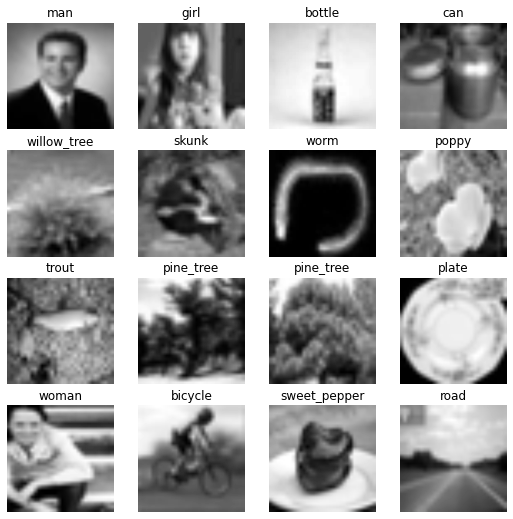

In [10]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [11]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 512
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
model_InceptionNET_3 = GoogLeNet(in_channels=1, num_classes=100).to(device)

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_InceptionNET_3.parameters(), lr=0.001)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [19]:
#torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=100

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_InceptionNET_3, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_InceptionNET_3,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 4.34516, Train acc: 4.75%


  1%|          | 1/100 [00:22<37:00, 22.43s/it]

Test Loss: 6.09967, Test acc: 1.81%
Epoch: 1 ----
Train Loss: 3.95068, Train acc: 9.32%


  2%|▏         | 2/100 [00:42<34:01, 20.83s/it]

Test Loss: 4.77879, Test acc: 4.78%
Epoch: 2 ----
Train Loss: 3.63498, Train acc: 14.36%


  3%|▎         | 3/100 [01:01<32:52, 20.34s/it]

Test Loss: 4.24372, Test acc: 8.07%
Epoch: 3 ----
Train Loss: 3.36645, Train acc: 18.20%


  4%|▍         | 4/100 [01:21<32:10, 20.10s/it]

Test Loss: 3.68923, Test acc: 13.10%
Epoch: 4 ----
Train Loss: 3.06577, Train acc: 23.57%


  5%|▌         | 5/100 [01:41<31:36, 19.96s/it]

Test Loss: 3.71530, Test acc: 14.42%
Epoch: 5 ----
Train Loss: 2.77286, Train acc: 29.17%


  6%|▌         | 6/100 [02:01<31:08, 19.87s/it]

Test Loss: 3.19941, Test acc: 21.42%
Epoch: 6 ----
Train Loss: 2.53523, Train acc: 33.28%


  7%|▋         | 7/100 [02:20<30:44, 19.84s/it]

Test Loss: 3.85985, Test acc: 14.58%
Epoch: 7 ----
Train Loss: 2.33844, Train acc: 37.82%


  8%|▊         | 8/100 [02:40<30:20, 19.79s/it]

Test Loss: 3.16308, Test acc: 23.51%
Epoch: 8 ----
Train Loss: 2.12008, Train acc: 42.83%


  9%|▉         | 9/100 [03:00<29:59, 19.77s/it]

Test Loss: 3.34504, Test acc: 24.41%
Epoch: 9 ----
Train Loss: 1.92624, Train acc: 47.07%


 10%|█         | 10/100 [03:20<29:40, 19.78s/it]

Test Loss: 2.91232, Test acc: 29.86%
Epoch: 10 ----
Train Loss: 1.72411, Train acc: 51.61%


 11%|█         | 11/100 [03:39<29:22, 19.80s/it]

Test Loss: 2.95132, Test acc: 31.04%
Epoch: 11 ----
Train Loss: 1.51174, Train acc: 56.84%


 12%|█▏        | 12/100 [03:59<29:00, 19.77s/it]

Test Loss: 3.02343, Test acc: 30.00%
Epoch: 12 ----
Train Loss: 1.32136, Train acc: 62.32%


 13%|█▎        | 13/100 [04:19<28:39, 19.76s/it]

Test Loss: 3.05889, Test acc: 30.35%
Epoch: 13 ----
Train Loss: 1.12241, Train acc: 67.40%


 14%|█▍        | 14/100 [04:39<28:18, 19.75s/it]

Test Loss: 3.26061, Test acc: 29.71%
Epoch: 14 ----
Train Loss: 0.94978, Train acc: 72.07%


 15%|█▌        | 15/100 [04:58<28:00, 19.78s/it]

Test Loss: 2.65927, Test acc: 37.31%
Epoch: 15 ----
Train Loss: 0.78575, Train acc: 77.09%


 16%|█▌        | 16/100 [05:18<27:40, 19.77s/it]

Test Loss: 2.73473, Test acc: 36.52%
Epoch: 16 ----
Train Loss: 0.63924, Train acc: 81.24%


 17%|█▋        | 17/100 [05:38<27:21, 19.78s/it]

Test Loss: 2.90039, Test acc: 35.46%
Epoch: 17 ----
Train Loss: 0.46442, Train acc: 86.72%


 18%|█▊        | 18/100 [05:58<27:04, 19.81s/it]

Test Loss: 3.21439, Test acc: 33.72%
Epoch: 18 ----
Train Loss: 0.39459, Train acc: 88.86%


 19%|█▉        | 19/100 [06:18<26:43, 19.80s/it]

Test Loss: 3.58002, Test acc: 33.33%
Epoch: 19 ----
Train Loss: 0.29691, Train acc: 91.89%


 20%|██        | 20/100 [06:37<26:21, 19.77s/it]

Test Loss: 3.61592, Test acc: 32.40%
Epoch: 20 ----
Train Loss: 0.19678, Train acc: 95.25%


 21%|██        | 21/100 [06:57<26:01, 19.77s/it]

Test Loss: 3.40175, Test acc: 34.61%
Epoch: 21 ----
Train Loss: 0.12845, Train acc: 97.23%


 22%|██▏       | 22/100 [07:17<25:41, 19.76s/it]

Test Loss: 3.24160, Test acc: 37.99%
Epoch: 22 ----
Train Loss: 0.09849, Train acc: 97.96%


 23%|██▎       | 23/100 [07:37<25:20, 19.75s/it]

Test Loss: 3.20041, Test acc: 38.96%
Epoch: 23 ----
Train Loss: 0.07684, Train acc: 98.53%


 24%|██▍       | 24/100 [07:56<24:59, 19.73s/it]

Test Loss: 3.38967, Test acc: 37.36%
Epoch: 24 ----
Train Loss: 0.05575, Train acc: 99.09%


 25%|██▌       | 25/100 [08:16<24:40, 19.74s/it]

Test Loss: 3.13350, Test acc: 41.11%
Epoch: 25 ----
Train Loss: 0.03221, Train acc: 99.64%


 26%|██▌       | 26/100 [08:36<24:20, 19.74s/it]

Test Loss: 3.26774, Test acc: 39.77%
Epoch: 26 ----
Train Loss: 0.01821, Train acc: 99.83%


 27%|██▋       | 27/100 [08:55<24:01, 19.75s/it]

Test Loss: 3.00573, Test acc: 42.83%
Epoch: 27 ----
Train Loss: 0.01172, Train acc: 99.93%


 28%|██▊       | 28/100 [09:15<23:42, 19.76s/it]

Test Loss: 3.12588, Test acc: 41.91%
Epoch: 28 ----
Train Loss: 0.00717, Train acc: 99.97%


 29%|██▉       | 29/100 [09:35<23:24, 19.78s/it]

Test Loss: 3.00326, Test acc: 44.07%
Epoch: 29 ----
Train Loss: 0.00390, Train acc: 99.99%


 30%|███       | 30/100 [09:55<23:03, 19.77s/it]

Test Loss: 2.94316, Test acc: 44.36%
Epoch: 30 ----
Train Loss: 0.00309, Train acc: 99.99%


 31%|███       | 31/100 [10:15<22:43, 19.76s/it]

Test Loss: 2.98689, Test acc: 44.14%
Epoch: 31 ----
Train Loss: 0.00223, Train acc: 100.00%


 32%|███▏      | 32/100 [10:34<22:22, 19.75s/it]

Test Loss: 2.95405, Test acc: 44.22%
Epoch: 32 ----
Train Loss: 0.00188, Train acc: 100.00%


 33%|███▎      | 33/100 [10:54<22:02, 19.74s/it]

Test Loss: 2.93926, Test acc: 44.81%
Epoch: 33 ----
Train Loss: 0.00170, Train acc: 100.00%


 34%|███▍      | 34/100 [11:14<21:42, 19.73s/it]

Test Loss: 2.97287, Test acc: 44.51%
Epoch: 34 ----
Train Loss: 0.00155, Train acc: 100.00%


 35%|███▌      | 35/100 [11:33<21:22, 19.73s/it]

Test Loss: 2.97774, Test acc: 44.24%
Epoch: 35 ----
Train Loss: 0.00138, Train acc: 100.00%


 36%|███▌      | 36/100 [11:53<21:03, 19.74s/it]

Test Loss: 2.98158, Test acc: 44.44%
Epoch: 36 ----
Train Loss: 0.00134, Train acc: 100.00%


 37%|███▋      | 37/100 [12:13<20:44, 19.75s/it]

Test Loss: 2.99543, Test acc: 44.17%
Epoch: 37 ----
Train Loss: 0.00121, Train acc: 100.00%


 38%|███▊      | 38/100 [12:33<20:24, 19.74s/it]

Test Loss: 2.99251, Test acc: 44.12%
Epoch: 38 ----
Train Loss: 0.00116, Train acc: 100.00%


 39%|███▉      | 39/100 [12:53<20:08, 19.81s/it]

Test Loss: 2.99833, Test acc: 44.35%
Epoch: 39 ----
Train Loss: 0.00103, Train acc: 100.00%


 40%|████      | 40/100 [13:13<19:49, 19.82s/it]

Test Loss: 3.00575, Test acc: 44.49%
Epoch: 40 ----
Train Loss: 0.00100, Train acc: 100.00%


 41%|████      | 41/100 [13:32<19:30, 19.84s/it]

Test Loss: 3.01297, Test acc: 44.55%
Epoch: 41 ----
Train Loss: 0.00096, Train acc: 100.00%


 42%|████▏     | 42/100 [13:52<19:09, 19.82s/it]

Test Loss: 3.01028, Test acc: 44.40%
Epoch: 42 ----
Train Loss: 0.00094, Train acc: 100.00%


 43%|████▎     | 43/100 [14:12<18:48, 19.80s/it]

Test Loss: 3.02052, Test acc: 44.29%
Epoch: 43 ----
Train Loss: 0.00084, Train acc: 100.00%


 44%|████▍     | 44/100 [14:32<18:27, 19.78s/it]

Test Loss: 3.03202, Test acc: 44.27%
Epoch: 44 ----
Train Loss: 0.00079, Train acc: 100.00%


 45%|████▌     | 45/100 [14:51<18:07, 19.78s/it]

Test Loss: 3.03057, Test acc: 44.40%
Epoch: 45 ----
Train Loss: 0.00074, Train acc: 100.00%


 46%|████▌     | 46/100 [15:11<17:48, 19.79s/it]

Test Loss: 3.04064, Test acc: 44.43%
Epoch: 46 ----
Train Loss: 0.00076, Train acc: 100.00%


 47%|████▋     | 47/100 [15:31<17:29, 19.79s/it]

Test Loss: 3.05775, Test acc: 44.35%
Epoch: 47 ----
Train Loss: 0.00070, Train acc: 100.00%


 48%|████▊     | 48/100 [15:51<17:08, 19.78s/it]

Test Loss: 3.04745, Test acc: 44.25%
Epoch: 48 ----
Train Loss: 0.00067, Train acc: 100.00%


 49%|████▉     | 49/100 [16:11<16:48, 19.77s/it]

Test Loss: 3.05898, Test acc: 44.34%
Epoch: 49 ----
Train Loss: 0.00064, Train acc: 100.00%


 50%|█████     | 50/100 [16:30<16:28, 19.76s/it]

Test Loss: 3.06301, Test acc: 44.37%
Epoch: 50 ----
Train Loss: 0.00061, Train acc: 100.00%


 51%|█████     | 51/100 [16:50<16:09, 19.79s/it]

Test Loss: 3.06339, Test acc: 44.53%
Epoch: 51 ----
Train Loss: 0.00060, Train acc: 100.00%


 52%|█████▏    | 52/100 [17:10<15:48, 19.76s/it]

Test Loss: 3.07727, Test acc: 44.45%
Epoch: 52 ----
Train Loss: 0.00058, Train acc: 100.00%


 53%|█████▎    | 53/100 [17:30<15:29, 19.78s/it]

Test Loss: 3.08361, Test acc: 44.45%
Epoch: 53 ----
Train Loss: 0.00055, Train acc: 100.00%


 54%|█████▍    | 54/100 [17:49<15:09, 19.77s/it]

Test Loss: 3.08027, Test acc: 44.30%
Epoch: 54 ----
Train Loss: 0.00055, Train acc: 100.00%


 55%|█████▌    | 55/100 [18:09<14:50, 19.79s/it]

Test Loss: 3.08212, Test acc: 44.59%
Epoch: 55 ----
Train Loss: 0.00050, Train acc: 100.00%


 56%|█████▌    | 56/100 [18:29<14:31, 19.80s/it]

Test Loss: 3.09203, Test acc: 44.57%
Epoch: 56 ----
Train Loss: 0.00049, Train acc: 100.00%


 57%|█████▋    | 57/100 [18:49<14:12, 19.83s/it]

Test Loss: 3.09028, Test acc: 44.36%
Epoch: 57 ----
Train Loss: 0.00047, Train acc: 100.00%


 58%|█████▊    | 58/100 [19:09<13:53, 19.84s/it]

Test Loss: 3.09974, Test acc: 44.36%
Epoch: 58 ----
Train Loss: 0.00045, Train acc: 100.00%


 59%|█████▉    | 59/100 [19:29<13:32, 19.83s/it]

Test Loss: 3.10341, Test acc: 44.62%
Epoch: 59 ----
Train Loss: 0.00043, Train acc: 100.00%


 60%|██████    | 60/100 [19:48<13:12, 19.81s/it]

Test Loss: 3.10503, Test acc: 44.49%
Epoch: 60 ----
Train Loss: 0.00043, Train acc: 100.00%


 61%|██████    | 61/100 [20:08<12:51, 19.78s/it]

Test Loss: 3.11142, Test acc: 44.30%
Epoch: 61 ----
Train Loss: 0.00041, Train acc: 100.00%


 62%|██████▏   | 62/100 [20:28<12:31, 19.78s/it]

Test Loss: 3.11168, Test acc: 44.46%
Epoch: 62 ----
Train Loss: 0.00040, Train acc: 100.00%


 63%|██████▎   | 63/100 [20:48<12:12, 19.80s/it]

Test Loss: 3.11304, Test acc: 44.49%
Epoch: 63 ----
Train Loss: 0.00038, Train acc: 100.00%


 64%|██████▍   | 64/100 [21:08<11:52, 19.79s/it]

Test Loss: 3.12490, Test acc: 44.48%
Epoch: 64 ----
Train Loss: 0.00038, Train acc: 100.00%


 65%|██████▌   | 65/100 [21:27<11:32, 19.80s/it]

Test Loss: 3.12724, Test acc: 44.39%
Epoch: 65 ----
Train Loss: 0.00037, Train acc: 100.00%


 66%|██████▌   | 66/100 [21:47<11:14, 19.83s/it]

Test Loss: 3.12982, Test acc: 44.27%
Epoch: 66 ----
Train Loss: 0.00036, Train acc: 100.00%


 67%|██████▋   | 67/100 [22:07<10:55, 19.87s/it]

Test Loss: 3.13065, Test acc: 44.45%
Epoch: 67 ----
Train Loss: 0.00033, Train acc: 100.00%


 68%|██████▊   | 68/100 [22:27<10:36, 19.90s/it]

Test Loss: 3.13702, Test acc: 44.42%
Epoch: 68 ----
Train Loss: 0.00033, Train acc: 100.00%


 69%|██████▉   | 69/100 [22:47<10:17, 19.92s/it]

Test Loss: 3.14432, Test acc: 44.40%
Epoch: 69 ----
Train Loss: 0.00032, Train acc: 100.00%


 70%|███████   | 70/100 [23:07<09:56, 19.90s/it]

Test Loss: 3.14761, Test acc: 44.34%
Epoch: 70 ----
Train Loss: 0.00031, Train acc: 100.00%


 71%|███████   | 71/100 [23:27<09:36, 19.87s/it]

Test Loss: 3.14625, Test acc: 44.27%
Epoch: 71 ----
Train Loss: 0.00031, Train acc: 100.00%


 72%|███████▏  | 72/100 [23:47<09:15, 19.85s/it]

Test Loss: 3.14947, Test acc: 44.44%
Epoch: 72 ----
Train Loss: 0.00031, Train acc: 100.00%


 73%|███████▎  | 73/100 [24:06<08:55, 19.83s/it]

Test Loss: 3.15478, Test acc: 44.40%
Epoch: 73 ----
Train Loss: 0.00029, Train acc: 100.00%


 74%|███████▍  | 74/100 [24:26<08:34, 19.80s/it]

Test Loss: 3.15914, Test acc: 44.60%
Epoch: 74 ----
Train Loss: 0.00028, Train acc: 100.00%


 75%|███████▌  | 75/100 [24:46<08:15, 19.80s/it]

Test Loss: 3.16219, Test acc: 44.35%
Epoch: 75 ----
Train Loss: 0.00028, Train acc: 100.00%


 76%|███████▌  | 76/100 [25:06<07:55, 19.81s/it]

Test Loss: 3.16677, Test acc: 44.43%
Epoch: 76 ----
Train Loss: 0.00027, Train acc: 100.00%


 77%|███████▋  | 77/100 [25:26<07:35, 19.80s/it]

Test Loss: 3.17099, Test acc: 44.42%
Epoch: 77 ----
Train Loss: 0.00026, Train acc: 100.00%


 78%|███████▊  | 78/100 [25:45<07:15, 19.81s/it]

Test Loss: 3.17011, Test acc: 44.16%
Epoch: 78 ----
Train Loss: 0.00026, Train acc: 100.00%


 79%|███████▉  | 79/100 [26:05<06:55, 19.80s/it]

Test Loss: 3.18381, Test acc: 44.26%
Epoch: 79 ----
Train Loss: 0.00025, Train acc: 100.00%


 80%|████████  | 80/100 [26:25<06:36, 19.84s/it]

Test Loss: 3.17846, Test acc: 44.54%
Epoch: 80 ----
Train Loss: 0.00024, Train acc: 100.00%


 81%|████████  | 81/100 [26:45<06:17, 19.86s/it]

Test Loss: 3.18422, Test acc: 44.43%
Epoch: 81 ----
Train Loss: 0.00024, Train acc: 100.00%


 82%|████████▏ | 82/100 [27:05<05:57, 19.84s/it]

Test Loss: 3.18792, Test acc: 44.37%
Epoch: 82 ----
Train Loss: 0.00023, Train acc: 100.00%


 83%|████████▎ | 83/100 [27:25<05:37, 19.88s/it]

Test Loss: 3.19437, Test acc: 44.38%
Epoch: 83 ----
Train Loss: 0.00023, Train acc: 100.00%


 84%|████████▍ | 84/100 [27:45<05:18, 19.90s/it]

Test Loss: 3.19288, Test acc: 44.27%
Epoch: 84 ----
Train Loss: 0.00021, Train acc: 100.00%


 85%|████████▌ | 85/100 [28:04<04:57, 19.85s/it]

Test Loss: 3.19383, Test acc: 44.52%
Epoch: 85 ----
Train Loss: 0.00022, Train acc: 100.00%


 86%|████████▌ | 86/100 [28:24<04:38, 19.87s/it]

Test Loss: 3.20235, Test acc: 44.47%
Epoch: 86 ----
Train Loss: 0.00020, Train acc: 100.00%


 87%|████████▋ | 87/100 [28:44<04:18, 19.91s/it]

Test Loss: 3.20344, Test acc: 44.36%
Epoch: 87 ----
Train Loss: 0.00021, Train acc: 100.00%


 88%|████████▊ | 88/100 [29:04<03:58, 19.90s/it]

Test Loss: 3.20837, Test acc: 44.49%
Epoch: 88 ----
Train Loss: 0.00020, Train acc: 100.00%


 89%|████████▉ | 89/100 [29:24<03:38, 19.89s/it]

Test Loss: 3.20596, Test acc: 44.28%
Epoch: 89 ----
Train Loss: 0.00020, Train acc: 100.00%


 90%|█████████ | 90/100 [29:44<03:18, 19.88s/it]

Test Loss: 3.21693, Test acc: 44.09%
Epoch: 90 ----
Train Loss: 0.00019, Train acc: 100.00%


 91%|█████████ | 91/100 [30:04<02:58, 19.85s/it]

Test Loss: 3.21669, Test acc: 44.10%
Epoch: 91 ----
Train Loss: 0.00018, Train acc: 100.00%


 92%|█████████▏| 92/100 [30:24<02:38, 19.83s/it]

Test Loss: 3.23007, Test acc: 44.31%
Epoch: 92 ----
Train Loss: 0.00017, Train acc: 100.00%


 93%|█████████▎| 93/100 [30:43<02:18, 19.80s/it]

Test Loss: 3.22962, Test acc: 44.27%
Epoch: 93 ----
Train Loss: 0.00017, Train acc: 100.00%


 94%|█████████▍| 94/100 [31:03<01:59, 19.83s/it]

Test Loss: 3.22717, Test acc: 44.43%
Epoch: 94 ----
Train Loss: 0.00017, Train acc: 100.00%


 95%|█████████▌| 95/100 [31:23<01:39, 19.85s/it]

Test Loss: 3.23499, Test acc: 44.08%
Epoch: 95 ----
Train Loss: 0.00017, Train acc: 100.00%


 96%|█████████▌| 96/100 [31:43<01:19, 19.81s/it]

Test Loss: 3.22903, Test acc: 44.17%
Epoch: 96 ----
Train Loss: 0.00016, Train acc: 100.00%


 97%|█████████▋| 97/100 [32:03<00:59, 19.81s/it]

Test Loss: 3.23510, Test acc: 44.31%
Epoch: 97 ----
Train Loss: 0.00016, Train acc: 100.00%


 98%|█████████▊| 98/100 [32:22<00:39, 19.82s/it]

Test Loss: 3.24045, Test acc: 44.05%
Epoch: 98 ----
Train Loss: 0.00015, Train acc: 100.00%


 99%|█████████▉| 99/100 [32:42<00:19, 19.82s/it]

Test Loss: 3.24126, Test acc: 44.12%
Epoch: 99 ----
Train Loss: 0.00015, Train acc: 100.00%


100%|██████████| 100/100 [33:02<00:00, 19.83s/it]

Test Loss: 3.23927, Test acc: 44.22%
Train time on cuda : 1982.584 seconds


In [20]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "03_InceptionNET_CIFAR100pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [21]:
#Saving the model
torch.save(obj=model_InceptionNET_3.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models/03_InceptionNET_CIFAR100pth


In [22]:
#Loading the model
#Create a new instance of the model and update the parameters
model_InceptionNET_CIFAR100 = GoogLeNet(in_channels=1, num_classes=100).to(device)
model_InceptionNET_CIFAR100.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [23]:
#Get model results
model_InceptionNET_CIFAR100_results = eval_model(
    model=model_InceptionNET_CIFAR100,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_InceptionNET_CIFAR100_results

100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


{'model_name': 'GoogLeNet',
 'model_loss': 3.239272356033325,
 'model_acc': 44.2155612244898}